In [1]:
### IMPORTS ###
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [3]:
### FUNCTIONS ###
def u_analytical_poisson_2d(global_domain_begin, global_indices, dx):
    point = global_domain_begin + (np.array(global_indices) - 1) * np.array(dx)
    func_val = np.prod(np.sin(np.pi * point))
    return func_val

In [4]:
block_size = 128
domain_begin = np.array([0.0, 0.0])
domain_end = np.array([1.0, 1.0])

In [5]:
file_path = '../output/system_solution.dat'  # Replace with your actual file path
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian
record_size = struct.calcsize(format_string)
approximate_solution = []

with open(file_path, 'rb') as file:
    while True:
        record_bytes = file.read(record_size)
        if not record_bytes:
            break  # End of file

        # Skip incomplete records
        if len(record_bytes) != record_size:
            print("Warning: Incomplete record skipped.")
            continue

        try:
            record = struct.unpack(format_string, record_bytes)
            approximate_solution.append(record[0])
        except struct.error as e:
            print(f"Error unpacking record: {e}")
            # Handle or log the error as needed

# Reshape the data into a 2D array
approximate_solution = np.array(approximate_solution)
approximate_solution = approximate_solution.reshape(block_size, block_size)


In [6]:
true_solution = np.zeros((block_size, block_size))
dx = abs(domain_end - domain_begin) / (block_size - 1)

for i in range(1, block_size + 1):
    for j in range(1, block_size + 1):
        true_solution[i - 1, j - 1] = u_analytical_poisson_2d(domain_begin, [i, j], dx)

error = np.abs(approximate_solution - true_solution)
print("Max error: ", np.max(error))
print("Mean error: ", np.mean(error))
print("Std dev error: ", np.std(error))


Max error:  3.118855784745023e-08
Mean error:  1.2442245474604659e-08
Std dev error:  9.197200442759714e-09


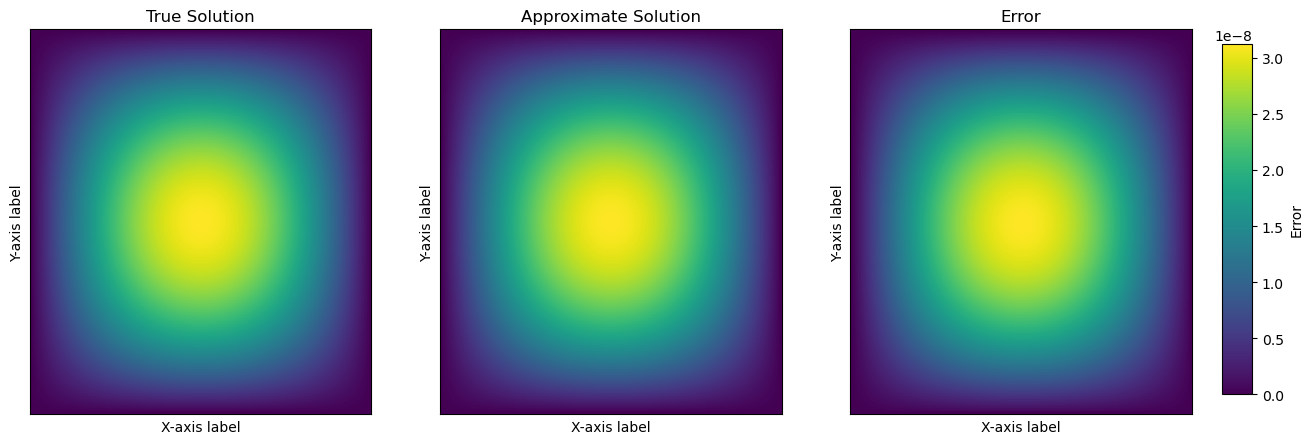

In [7]:
# Plot the true solution, the approximate solution, and the error side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the true solution
im0 = axs[0].imshow(true_solution, cmap='viridis', aspect='auto')
axs[0].set_title('True Solution')
axs[0].set_xlabel('X-axis label')
axs[0].set_ylabel('Y-axis label')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].grid(False)

# Plot the approximate solution
im1 = axs[1].imshow(approximate_solution, cmap='viridis', aspect='auto')
axs[1].set_title('Approximate Solution')
axs[1].set_xlabel('X-axis label')
axs[1].set_ylabel('Y-axis label')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].grid(False)

# Plot the error
im2 = axs[2].imshow(error, cmap='viridis', aspect='auto')
axs[2].set_title('Error')
axs[2].set_xlabel('X-axis label')
axs[2].set_ylabel('Y-axis label')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].grid(False)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Error')

plt.show()

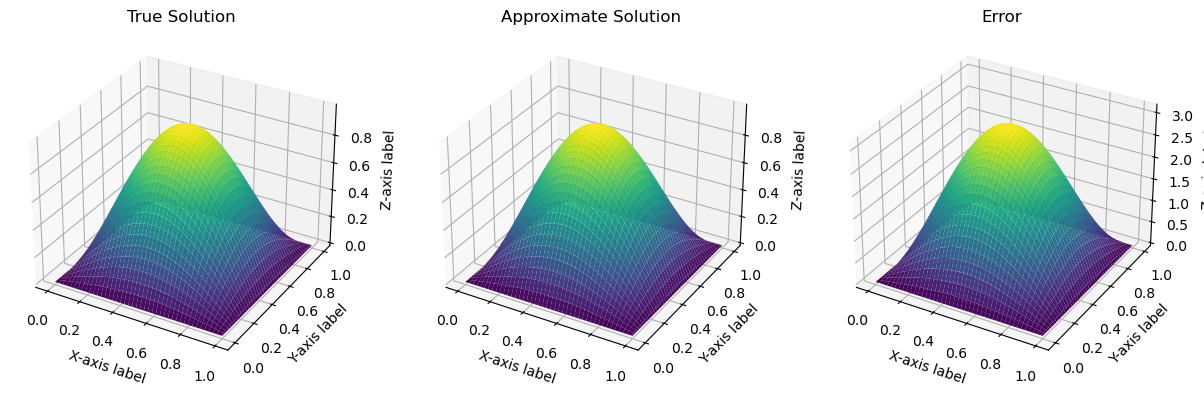

In [8]:
# Create meshgrid for 3D plots
x = np.linspace(domain_begin[0], domain_end[0], block_size)
y = np.linspace(domain_begin[1], domain_end[1], block_size)
X, Y = np.meshgrid(x, y)

# Plot the true solution, the approximate solution, and the error side by side
fig = plt.figure(figsize=(15, 5))

# Plot the true solution
ax0 = fig.add_subplot(131, projection='3d')
ax0.plot_surface(X, Y, true_solution, cmap='viridis')
ax0.set_title('True Solution')
ax0.set_xlabel('X-axis label')
ax0.set_ylabel('Y-axis label')
ax0.set_zlabel('Z-axis label')

# Plot the approximate solution
ax1 = fig.add_subplot(132, projection='3d')
ax1.plot_surface(X, Y, approximate_solution, cmap='viridis')
ax1.set_title('Approximate Solution')
ax1.set_xlabel('X-axis label')
ax1.set_ylabel('Y-axis label')
ax1.set_zlabel('Z-axis label')

# Plot the error
ax2 = fig.add_subplot(133, projection='3d')
surf = ax2.plot_surface(X, Y, error, cmap='viridis')
ax2.set_title('Error')
ax2.set_xlabel('X-axis label')
ax2.set_ylabel('Y-axis label')
ax2.set_zlabel('Z-axis label')

plt.show()


In [9]:
np.savetxt('approximate_solution.txt', approximate_solution, fmt='%.3f', delimiter=' ')
np.savetxt('true_solution.txt', true_solution, fmt='%.3f', delimiter=' ')